# Churn Model 

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import ShuffleSplit
from sklearn import cross_validation
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from sklearn import linear_model
from sklearn import grid_search
import sklearn
import statsmodels.api as sm
from pprint import pprint
%matplotlib inline

### Predicting Churn

In [2]:
#read in the data
churn_data = pd.read_csv('../data/churn.csv')

In [3]:
churn_data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [4]:
# look at the dat types
for idx, feature in enumerate(churn_data.columns):
    print feature, ":", churn_data.dtypes[idx]

State : object
Account Length : int64
Area Code : int64
Phone : object
Int'l Plan : object
VMail Plan : object
VMail Message : int64
Day Mins : float64
Day Calls : int64
Day Charge : float64
Eve Mins : float64
Eve Calls : int64
Eve Charge : float64
Night Mins : float64
Night Calls : int64
Night Charge : float64
Intl Mins : float64
Intl Calls : int64
Intl Charge : float64
CustServ Calls : int64
Churn? : object


***Object type columns will need to be converted to numeric values before feeding into the model.***

In [5]:
# Let's take a peak at some summary statistics
churn_data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


*** The means of the numerical variables are of different magnitude meaning I will certainly need to normalize data.  Before normalizing, though, I need to perform some EDA***

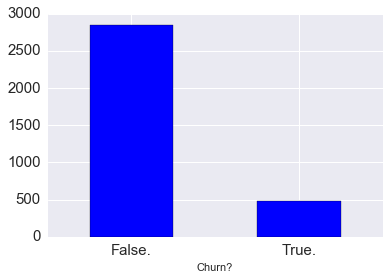

In [6]:
#Looking at distribution of response variable
new_style = {'grid': False}
churn_data.groupby('Churn?').apply(len).plot(kind='bar', fontsize = 15, rot = 360)
plt.show()

***Significantly unbalanced classes.  AdaBoost and Random Forests have the ability to handle unbalanced classes.  In addition, I'll need to look at other metrics besides accuracy, precision and recall when comparing classifiers. Looking at AUC Roc Curves and the confusion matrix of each model will be good indicators of which model to prefer.  Also, it may be worth looking into sub-sampling methods to ensure the model does not learn to always prefer "False", but I would like to proceed with the raw data before subsampling.***


In [7]:
# These data points will just contribute to noise
clean_churn = churn_data.drop(['Area Code','State', 'Phone'], axis = 1)

In [8]:
#sanity check
clean_churn.head()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [9]:
#set target variable to binary (1,0) and remove from clean data
#Source - http://stackoverflow.com/questions/19913659/pandas-conditional-creation-of-a-series-dataframe-column
clean_churn["Churn?"] = np.where(clean_churn["Churn?"]=="True.", 1.0, 0.0)
y = clean_churn['Churn?']
#clean_churn = clean_churn.drop(['Churn?'], axis=1)

In [10]:
#Sanity check
np.unique(y)

array([ 0.,  1.])

In [11]:
#Source - http://stackoverflow.com/questions/19913659/pandas-conditional-creation-of-a-series-dataframe-column
# Changing the yes/no to boolean
clean_churn["Int'l Plan"] = np.where(clean_churn["Int'l Plan"]=="yes", 1.0, 0.0)
clean_churn["VMail Plan"] = np.where(clean_churn["VMail Plan"]=="yes", 1.0, 0.0)

In [12]:
#Another Sanity check
print np.unique(clean_churn["Int'l Plan"]), np.unique(clean_churn["VMail Plan"])

[ 0.  1.] [ 0.  1.]


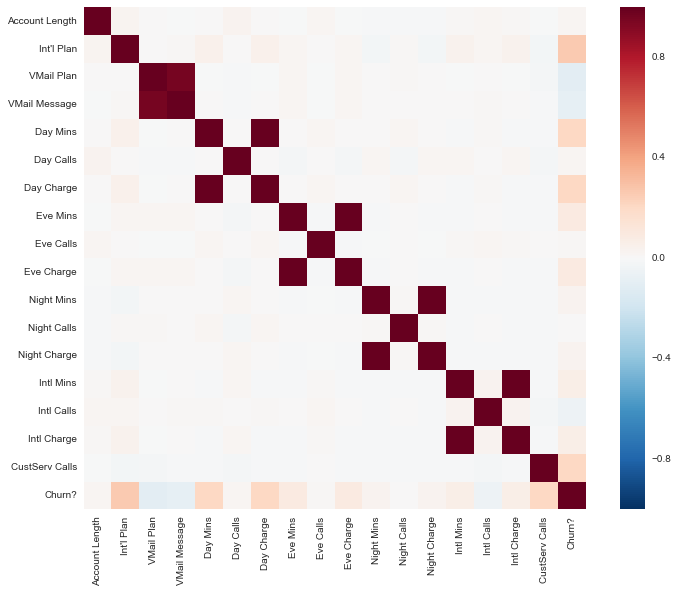

                Account Length  Int'l Plan  VMail Plan  VMail Message  \
Account Length        1.000000    0.024735    0.002918      -0.004628   
Int'l Plan            0.024735    1.000000    0.006006       0.008745   
VMail Plan            0.002918    0.006006    1.000000       0.956927   
VMail Message        -0.004628    0.008745    0.956927       1.000000   
Day Mins              0.006216    0.049396   -0.001684       0.000778   
Day Calls             0.038470    0.003755   -0.011086      -0.009548   
Day Charge            0.006214    0.049398   -0.001686       0.000776   
Eve Mins             -0.006757    0.019100    0.021545       0.017562   
Eve Calls             0.019260    0.006114   -0.006444      -0.005864   
Eve Charge           -0.006745    0.019106    0.021559       0.017578   
Night Mins           -0.008955   -0.028905    0.006079       0.007681   
Night Calls          -0.013176    0.012451    0.015553       0.007123   
Night Charge         -0.008960   -0.028913    0.006

In [13]:
corrmat = clean_churn.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, square=True)

plt.show()
print corrmat

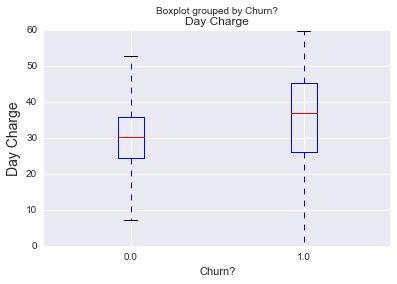

In [14]:
#box plot of distribution of pitch type and start speed
clean_churn.boxplot(column = 'Day Charge', by = 'Churn?')
plt.ylabel('Day Charge', fontsize = 14)
plt.show()

In [15]:
churned = clean_churn['CustServ Calls'][clean_churn['Churn?'] == 1.0]

In [16]:
no_churn =clean_churn['CustServ Calls'][clean_churn['Churn?'] == 0.0]

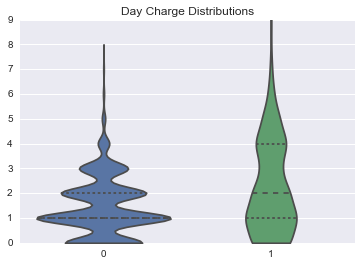

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.label.set_color('red')
sns.violinplot(data=[no_churn,churned], inner='quartile', cut=0)
sns.despine()
plt.title('Day Charge Distributions')
plt.show()

In [18]:
corrmat["Churn?"]

Account Length    0.016541
Int'l Plan        0.259852
VMail Plan       -0.102148
VMail Message    -0.089728
Day Mins          0.205151
Day Calls         0.018459
Day Charge        0.205151
Eve Mins          0.092796
Eve Calls         0.009233
Eve Charge        0.092786
Night Mins        0.035493
Night Calls       0.006141
Night Charge      0.035496
Intl Mins         0.068239
Intl Calls       -0.052844
Intl Charge       0.068259
CustServ Calls    0.208750
Churn?            1.000000
Name: Churn?, dtype: float64

In [19]:
clean_churn.head()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [20]:
# just may be a good idea to keep track of the numerical and categorical data points
num_vars = ['Account Length','VMail Message','Day Mins','Day Calls','Eve Mins','Eve Charge',
            'Night Mins', 'Night Calls', 'Night Charge','Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls']
cat_vars = ["Int'l Plan", 'VMail Plan']

all_cols = ["Int'l Plan", 'VMail Plan','Account Length','VMail Message','Day Mins','Day Calls','Eve Mins','Eve Charge',
            'Night Mins', 'Night Calls', 'Night Charge','Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls' ]

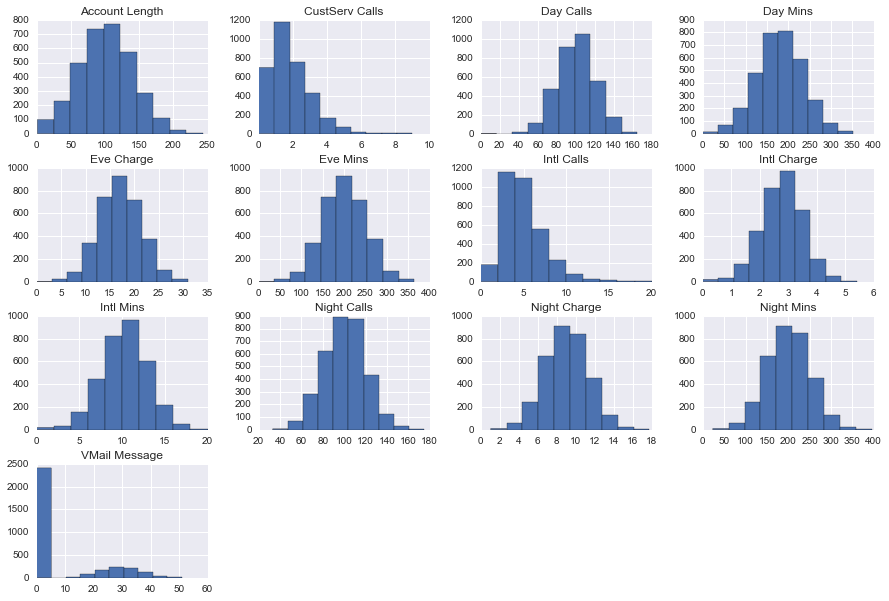

In [21]:
#looking at the distribution of the numerical features
clean_churn[num_vars].hist(bins=10, figsize=(15,10))
plt.show()

***The numerical data seems normally distributed besides customer service calls, intl calls, and vmail message.***

In [ ]:
#scatter matrix of numerical vars
ax = scatter_matrix(clean_churn[num_vars], figsize=(15,15))

***The minutes and charges for intl, night, day, and evening are highly correlated with each other. I also need to see if there is any correlation between any of the numeric and the categorical features as well. Let's look at a correlation matrix to confirm.*** 

In [ ]:
#Correlation Matrix
#Source - https://stanford.edu/~mwaskom/software/seaborn/examples/network_correlations.html
corrmat = clean_churn.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, square=True)
plt.show()
print corrmat

### Multicolinearity

*** There is high multicollinearity between a number of features in the data set.  As mentioned above, international minutes and international calls have 100% correlation, night calls and night charges have 100% correlation, evening calls and evening minutes have 100% correlation, and daily minutes and daily calls have 100% correlation.  In addtion, there is a 95.6% correlation between Voicemail plan and Voicemail message.  For the 100% correlated features, I am going to just completely drop one of the features (all of the calls features).  In addition, I am going to drop the voicemail message feature and keep the voicemail plan feature.  To me, it wouldn't make sense to have a voicemall message feature without a voicemail plan feature.***

In [22]:
#dropping collinear features
clean_churn = clean_churn.drop(['Day Mins','Night Mins', 'Eve Mins', 'Intl Mins',
                               'VMail Message'], axis = 1)

In [23]:
#sanity chek
clean_churn.head()

,Account Length,Int'l Plan,VMail Plan,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,128,0,1,110,45.07,99,16.78,91,11.01,3,2.70,1,0
1,107,0,1,123,27.47,103,16.62,103,11.45,3,3.70,1,0
2,137,0,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0
3,84,1,0,71,50.90,88,5.26,89,8.86,7,1.78,2,0
4,75,1,0,113,28.34,122,12.61,121,8.41,3,2.73,3,0


In [24]:
#Make data into matrix format so the models will cleanly take the data
X = clean_churn.as_matrix().astype(np.float)

In [29]:
X[:,0].mean()

101.06480648064806

In [30]:
X[:,0].std()

39.816131567159452

In [35]:
(abs(102-101))/39.816131567159452

0.02511544845368165

In [25]:
X.mean()

35.979460176786908

In [26]:
#Quick look at the matrix
X[:3]

array([[ 128.  ,    0.  ,    1.  ,  110.  ,   45.07,   99.  ,   16.78,
          91.  ,   11.01,    3.  ,    2.7 ,    1.  ,    0.  ],
       [ 107.  ,    0.  ,    1.  ,  123.  ,   27.47,  103.  ,   16.62,
         103.  ,   11.45,    3.  ,    3.7 ,    1.  ,    0.  ],
       [ 137.  ,    0.  ,    0.  ,  114.  ,   41.38,  110.  ,   10.3 ,
         104.  ,    7.32,    5.  ,    3.29,    0.  ,    0.  ]])

In [32]:
#Normalizing data before inputing to model
SSinstance = StandardScaler()
X = SSinstance.fit_transform(X)

In [33]:
X[:3]

array([[ 0.67648946, -0.32758048,  1.6170861 ,  0.47664315,  1.56703625,
        -0.05594035, -0.07042665, -0.46549436,  0.86602851, -0.60119509,
        -0.0856905 , -0.42793202, -0.41167182],
       [ 0.14906505, -0.32758048,  1.6170861 ,  1.12450284, -0.33401297,
         0.14486653, -0.10754944,  0.14782467,  1.05938994, -0.60119509,
         1.2411686 , -0.42793202, -0.41167182],
       [ 0.9025285 , -0.32758048, -0.61839626,  0.67598459,  1.168464  ,
         0.49627857, -1.57389963,  0.19893459, -0.75557074,  0.21153386,
         0.69715637, -1.1882185 , -0.41167182]])

In [37]:
print np.round(X[:,0].mean(),2), np.round(X[:,1].mean(),2)
print X[:,0].std(), X[:,1].std()

0.0 -0.0
1.0 1.0


In [ ]:
X.shape

### PCA Analysis

***If it's possible to reduce the dimensionality into only a few principal components, then the curse of dimensionality may not be as big of a problem when fitting. In addition, we can tell which features have the most variance in the data***

In [ ]:
cor_mat1 = np.corrcoef(X.T)
eig_vals, eig_vecs = np.linalg.eig(cor_mat1)


In [ ]:
# Looking at sorted eigenvalues
rounded_eigs = [np.around(i,5) for i in eig_vals]
sorted_eigs  = sorted(rounded_eigs, reverse = True)
print 'Eigenvalues in descending order:'
for i in sorted_eigs:
    print i 

***Most of the variance in the data cannot be explained in only a few principal components. PCA isn't going to be too
helpful due to the fact that the variance is spread across all of the components (12 of the 12 features).***

### Functions for Model Comparison

In [ ]:
def fit_score(clf,xtrain,ytrain,xtest,ytest):
    """Fit the estimator and print the accuracy"""
    clf.fit(xtrain,ytrain)
    score = clf.score(xtest,ytest)
    print "Accuracy: %0.2f"% score,"%" 
    
def cv(clf,xtrain,ytrain,cv,scoretype):
    """Cross validate the estimator and perform 5-fold cross validation on the training set.  Print
    out the mean and std of the scores."""
    scores = cross_validation.cross_val_score(clf, xtrain, ytrain, cv=5, scoring=scoretype)
    print("%s: %0.2f (+/- %0.2f)" % (scoretype, scores.mean(), scores.std()))


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    """ Plot a confusion matrix"""
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(set(y_test)))
    plt.xticks(tick_marks, set(y_test), rotation=45)
    plt.yticks(tick_marks, set(y_test))
    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
      
        
def Roc_curve_plot(clf, X_test, y_test):
    """Plot a ROC Curve of the estimator"""
    probsLR = list(clf.predict_proba(X_test)[:, 1])
    fpr, tpr, threshLR = metrics.roc_curve(list(y_test), probsLR)
    predictions = clf.predict(X_test)
    print "AUC:", np.around(metrics.auc(fpr,tpr),3)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1])
    Max = Roc_truth(clf,X_test, y_test)
    x,y = Max[0], Max[1]
    plt.plot(x, y, 'or')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity, Recall)")
    plt.title("ROC plot of Churn Data")
    plt.show()
    
def Roc_truth(clf, X_test, y_test,low=.00,high=.1):
    "Determine the max TPR with a FPR range of 0-10%"
    probsLR = list(clf.predict_proba(X_test)[:, 1])
    fpr, tpr, threshLR = metrics.roc_curve(list(y_test), probsLR)
    maxlist = []
    for idx, i in enumerate(fpr):
        if low <= i<= high:
            maxlist.append((fpr[idx],tpr[idx]))
    return np.around(max(maxlist, key = lambda x:x[1]),3)

def important_feat(clf, data):
    "Create inputs for plotting feature importance"
    names = []
    values = []
    features = [(data.columns[idx],feature)for idx, feature in enumerate(clf.feature_importances_)]
    sorted_features = sorted(features, key = lambda x: x[1], reverse = True)
    for name, value in features_value:
        names.append(name)
        values.append(value)
    return sorted_features, names, values

### Model Comparison

***I'll need to look at other metrics besides accuracy, precision and recall when comparing classifiers. Looking at AUC Roc Curves,the confusion matrix, and potentially the F1 score of each model will be good indicators of which model to prefer. My thoughts are that if it's possible, we would want to minimize our false negatives (missing people that churn) even if it means we increase our false positives(misclassifying non-churners as churners).  Since sci-kit learn's gridsearchcv function does not have a comparison for the confusion matrix, my comparison metric will be the metrics.roc_auc.  Generally, the best possible prediction method would yield a point in the upper left corner or coordinate (0,1) of the ROC space, representing 100% sensitivity (no false negatives) and 100% specificity (no false positives).  In addition, the confusion matrix should maximize TP's and TN's, while minimizing FP's and FN's.  I'll also look at what is the maximum TPR between a FPR of 0% and 10%.  I am assuming the max the telecom company would allow would be a 10% FPR, so then that would give me an idea of what the TPR looks like at 10% FPR.***

In [ ]:
#Test train split with a random state to compare with other models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 1)

### Logistic Regression

***Logistic is a basic classifier which is a typical starting point for classifying a binary output.  It is simple to implement, interpretable, and is often very effective. In addition, we can interpret the coefficients in multiplicative terms with respect to the odds.E.g., the interpretation of β1 is, holding all the other variables/features fixed, for every increase of 1 in X1, the odds of Y=1 increases by a factor of exp(β1).***

In [ ]:
clfLR = linear_model.LogisticRegression(solver='lbfgs',random_state=1)
fit_score(clfLR,X_train,y_train,X_test,y_test)
cv(clfLR,X_train,y_train,5,"roc_auc")
predictions = clfLR.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print cm
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm)  
plt.figure(figsize=(7,5))
Roc_curve_plot(clfLR,X_test,y_test)
print "Max True Positive Rate (TPR) under a maximum of a 10% False Positive Rate (FPR). Output is (FPR, TPR):"
Roc_truth(clfLR, X_test, y_test)

### Random Forest

*** Another extension of the Decision Tree classifier is the Random Forest.  The Random Forest algorithm is an an ensemble classifier that repeatedly and  randomly selects data from the dataset (with replacement) and builds a Decision Tree with each new sample.The default is to have the randomly selected data be the same size as the initial dataset. Note that since we are sampling with replacement, many data points will be repeated in the sample and many won't be included.Random Forests also limit each node of the Decision Tree to only consider splitting on a random subset of the features. Again we get all of the inherit benefits of a decsion tree, while also providing us many hyper parameters to investigate and tweak for potential improvments to the model.***

***Easily interpretable and feature importance is identifiable***

***Handles missing values and outliers***

***Non-parametric/non-linear/model complex phenomenom***

***Computationally cheap to predict***

***Can handle irrelevant features***

***Mixed data (nominal and continuous)***

In [ ]:
#Random Forests Classifier
clfrf = ensemble.RandomForestClassifier(random_state=1, n_jobs=4)
fit_score(clfrf,X_train,y_train,X_test,y_test)
cv(clfrf,X_train,y_train,5,"roc_auc")
predictions = clfrf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print cm
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm)  
plt.figure(figsize=(7,5))
Roc_curve_plot(clfrf,X_test,y_test)
print "Max True Positive Rate (TPR) under a maximum of a 10% False Positive Rate (FPR). Output is (FPR, TPR):"
Roc_truth(clfrf, X_test, y_test)

### AdaBoost

***  AdaBoost is not as sensitive to unbalanced data as other classifiers. It utlizes a simple estimator like a decision tree and focuses on providing each tree a description of the mistakes of the last tree (through the cost "loss" function). Each tree is given the opportunity to adapt itself to the weaknesses of previous trees. Finally the end classifier is similar to a random forest, where each of the trees votes, weighted inversely to its own total error.  At the core, it is using a decision tree which enables the classifier to inherit the many benefits of a decision tree:***

In [ ]:
#Fitting the Classifier and evaluating metrics
clfab = ensemble.AdaBoostClassifier(random_state=1)
fit_score(clfab,X_train,y_train,X_test,y_test)
cv(clfab,X_train,y_train,5,"roc_auc")
predictions = clfab.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print cm
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm)  
plt.figure(figsize=(7,5))
Roc_curve_plot(clfab,X_test,y_test)
print "Max True Positive Rate (TPR) under a maximum of a 10% False Positive Rate (FPR). Output is (FPR, TPR):"
Roc_truth(clfab, X_test, y_test)

### Picking a model to hyper tune

***After comparing logistic regression, ada boost, and random forests, the random forest algorithm achieved better results across the board. At a 5% FPR the Random Forest had a 76% TPR compared to Ada Boost's 9% FPR with only a 62% TPR and compared to logistic regressions 9.5% FPR with only a 43% TPR.  In addition, the TP's and FN's for the Random Forest are 42 and 9, while adaboost's are 58 and 28 and logistic regression's are 81 and 17.  Since there is such substantial evidence for the Random Forest algorithm versus the other two, I chose to move forward with the Random Forest algorithm to start hyper tuning parameters.***

### Grid Searching Hyper Parameters for Random Forest

*** The Random Forest algorithm has a ton of hyper paramters that can be tuned to obtain an optimal classifier.  I am going to use grid search and a scoring comparison of 'roc_auc' when comparing the random forest models.  I am choosing roc_auc because it is more robust to unbalanced classes, and it was one of my measures for comparing the prior models.***

In [ ]:
import time
start = time.time()
clfERF = ensemble.RandomForestClassifier()
paramsvec = [{'criterion':['gini','entropy'],'n_estimators':[10,20,50,100,150,300,500],'max_features':['auto',5,10],
              'max_depth':[None,5,10,15],'min_samples_split':[2,3,4],
              "min_samples_leaf":[1,2],"class_weight":[None, "balanced"], 'random_state':[1]}]
#Building GridSearch object
gs_RF = grid_search.GridSearchCV(clfERF,paramsvec,scoring='roc_auc', cv=5, n_jobs=-1)
gs_RF.fit(X_train,y_train)

#How long did it take?
end = time.time()
elapsed = end - start
print("Time taken for GridSearch: ", elapsed, "seconds.")
print("Best Score: %0.2f  " % gs_RF.best_score_)
print("Best Parameters: ", gs_RF.best_params_)

In [ ]:
clfoptimal = ensemble.RandomForestClassifier(random_state = 1,min_samples_leaf=1, n_estimators=20, 
                                         min_samples_split=3, max_features = 10, max_depth=10,criterion='entropy',
                                         class_weight = 'balanced')

In [ ]:
# Testing the Optimal classifier
fit_score(clfoptimal,X_train,y_train,X_test,y_test)
cv(clfoptimal,X_train,y_train,5,"roc_auc")
predictions = clfoptimal.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print cm
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm)  
plt.figure(figsize=(7,5))
Roc_curve_plot(clfoptimal,X_test,y_test)
print "Max True Positive Rate (TPR) under a maximum of a 10% False Positive Rate (FPR). Output is (FPR, TPR):"
Roc_truth(clfoptimal, X_test, y_test)

In [ ]:
#Plotting feature importance
features, names, values=important_feat(clfoptimal,clean_churn)
index = np.arange(17)
bar_width = 0.35
plt.figure(figsize=(10,5))
rects1 = plt.bar(index, values, bar_width,
                 color='b')
plt.title('Feature Importance',fontsize=20)
plt.xticks(range(len(values)),names, rotation=45, fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()

### Conclusion

***After comparing logistic regression, Ada Boost, and Random Forest (RF) I decided to go with the Random Forest Algorithm due to the fact that it performed better when comparing the roc curves, the confusion matrices, and and the TPR when the FPR was under 10%.  Once I decided to go with the Random Forest, I decided to tune the hyper parameters to see if I could minimize the true negatives (said they aren't churners when they are) and false positives (said they are churners when they aren't).  I actually increased my false positives by 3, but I was able to substantially decrease my true negatives from 42 to 25. The TPR for the original RF model was 73% at 5% FPR, while the optimized model had a TPR of 80.6% with a FPR of around 6%.  In addition, Random Forests provide the additional benefit of deriving feature importance.  It is easy to see from the above graph that the number of day minutes, the day charge, the number of customer service calls were the prominent features driving the model.  This information could then be used to help target specific areas within the company to make potential adjustments to decrease churn.***